<a href="https://colab.research.google.com/github/ThierrryScotto/Finetunig-BERT/blob/main/Finetunig_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
!pip install -U -q transformers
!pip install -U -q accelerate
!pip install -U -q datasets
!pip install -U -q bertviz
!pip install -U -q umap-learn
!pip install seaborn -q --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.2/139.2 kB 8.7 M

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from transformers import AutoTokenizer
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
from transformers import AutoModel

In [8]:
url_dataset = 'https://raw.githubusercontent.com/ThierrryScotto/Finetunig-BERT/main/twitter_multi_class_sentiment.csv'
df = pd.read_csv(url_dataset)
df

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


# Data Analysis

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


In [10]:
df.isnull().sum()

,0
text,0
label,0
label_name,0


In [11]:
df['label'].value_counts()

,count
label,
1,5362
0,4666
3,2159
4,1937
2,1304
5,572


Text(0, 0.5, 'Emotions')

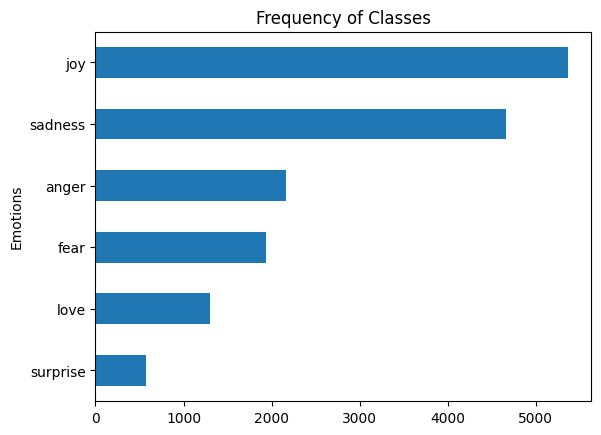

In [12]:
label_counts = df['label_name'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title('Frequency of Classes')
plt.ylabel('Emotions')

In [13]:
df['words per tweet'] = df['text'].str.split().apply(len)
df

,text,label,label_name,words per tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness,24
15996,i am now turning and i feel pathetic that i am...,0,sadness,20
15997,i feel strong and good overall,1,joy,6
15998,i feel like this was such a rude comment and i...,3,anger,14


<Axes: title={'center': 'words per tweet'}, xlabel='label_name'>

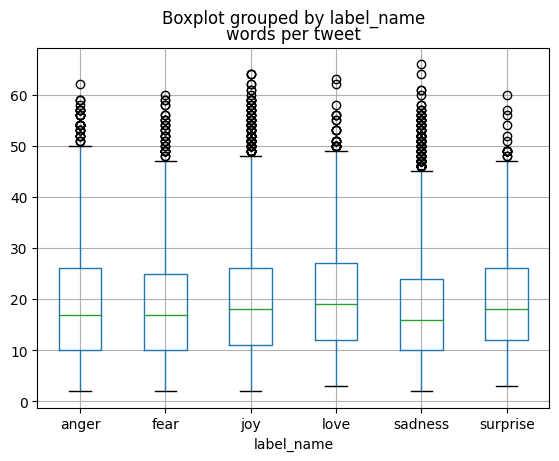

In [14]:
df.boxplot("words per tweet", by='label_name')

# Data Preparation

### Tokenizing Test

In [15]:
model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [16]:
text = "I love machne learning! Tokenization is awesome!"

encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1045, 2293, 24532, 2638, 4083, 999, 19204, 3989, 2003, 12476, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [17]:
tokenizer.vocab

{'##eno': 16515,
 'undergoes': 29129,
 '1827': 12309,
 'charting': 17918,
 '1000': 6694,
 'automobiles': 19207,
 '##ahl': 28083,
 '##tray': 28473,
 'differently': 11543,
 '##ian': 2937,
 'mounted': 5614,
 '[unused488]': 493,
 '##bal': 10264,
 'aragon': 16146,
 'verona': 20197,
 'bones': 5944,
 '##utter': 26878,
 'metz': 24424,
 '##zzling': 20838,
 '##imov': 25299,
 'intentions': 11174,
 'saber': 25653,
 '##lino': 25226,
 '[unused378]': 383,
 'ruined': 9868,
 'validity': 16406,
 'penalties': 12408,
 'raped': 15504,
 '##ul': 5313,
 'girl': 2611,
 '[unused521]': 526,
 'segregated': 24382,
 '##一': 30266,
 'metaphysical': 29081,
 'carlo': 9758,
 'cummings': 20750,
 '##ত': 29898,
 'caring': 11922,
 '―': 1518,
 'turbulence': 29083,
 'working': 2551,
 'plural': 13994,
 'again': 2153,
 '##ovo': 16059,
 'fishermen': 16532,
 'grooves': 25880,
 '##tur': 20689,
 '##kt': 25509,
 'adjective': 24931,
 'adherents': 25712,
 'lavish': 22689,
 'bucharest': 14261,
 'missile': 7421,
 'pensacola': 26073,
 'd

In [18]:
len(tokenizer.vocab)

30522

## Data Loader and Train Test Split

In [19]:
df

,text,label,label_name,words per tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness,24
15996,i am now turning and i feel pathetic that i am...,0,sadness,20
15997,i feel strong and good overall,1,joy,6
15998,i feel like this was such a rude comment and i...,3,anger,14


In [20]:
train, test = train_test_split(df, test_size=0.3, stratify=df['label_name'])
test, validation = train_test_split(test, test_size=1/3, stratify=test['label_name'])

In [21]:
print(train.shape)
print(test.shape)
print(validation.shape)

(11200, 4)
(3200, 4)
(1600, 4)


In [22]:
dataset = DatasetDict(
    {
        'train': Dataset.from_pandas(train, preserve_index=False),
        'test': Dataset.from_pandas(test, preserve_index=False),
        'validation': Dataset.from_pandas(validation, preserve_index=False)
    }
)

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'words per tweet'],
        num_rows: 1600
    })
})

## Tokenization of the emotions

In [23]:
dataset['train'][129]

{'text': 'i feel remorseful for not making the most with them',
 'label': 0,
 'label_name': 'sadness',
 'words per tweet': 10}

In [24]:
def tokenize(batch):
    temp = tokenizer(batch['text'], padding=True, truncation=True, max_length=512)
    return temp

In [25]:
print(tokenize(dataset['train'][129]))

{'input_ids': [101, 1045, 2514, 23124, 3993, 2005, 2025, 2437, 1996, 2087, 2007, 2068, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [26]:
print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 1045, 2467, 4025, 2000, 2031, 2070, 2785, 1997, 2166, 2039, 20192, 10175, 2030, 3176, 2147, 6911, 2008, 3084, 2009, 2524, 2000, 2514, 16082, 2055, 1996, 9046, 11938, 102], [101, 1045, 2347, 2102, 3110, 5506, 2012, 2643, 2030, 4854, 2005, 2032, 4352, 2023, 2000, 4148, 2000, 2033, 1045, 2001, 2074, 6517, 102, 0, 0, 0, 0, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]]}


In [27]:
dataset['train'][0], dataset['train'][1]

({'text': 'i always seem to have some kind of life upheaval or additional work stress that makes it hard to feel thrilled about the upcoming holidays',
  'label': 1,
  'label_name': 'joy',
  'words per tweet': 25},
 {'text': 'i wasnt feeling mad at god or angry for him allowing this to happen to me i was just sad',
  'label': 3,
  'label_name': 'anger',
  'words per tweet': 20})

dataset with tokenized texts

In [28]:
emotion_encoded = dataset.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [29]:
emotion_encoded['train'][0]

{'text': 'i always seem to have some kind of life upheaval or additional work stress that makes it hard to feel thrilled about the upcoming holidays',
 'label': 1,
 'label_name': 'joy',
 'words per tweet': 25,
 'input_ids': [101,
  1045,
  2467,
  4025,
  2000,
  2031,
  2070,
  2785,
  1997,
  2166,
  2039,
  20192,
  10175,
  2030,
  3176,
  2147,
  6911,
  2008,
  3084,
  2009,
  2524,
  2000,
  2514,
  16082,
  2055,
  1996,
  9046,
  11938,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,

In [30]:
# label2id and id2label

label2id = { x['label_name'] : x['label'] for x in dataset['train'] }
id2label = { v : k for k, v in label2id.items() }

label2id, id2label

({'joy': 1, 'anger': 3, 'sadness': 0, 'love': 2, 'surprise': 5, 'fear': 4},
 {1: 'joy', 3: 'anger', 0: 'sadness', 2: 'love', 5: 'surprise', 4: 'fear'})

# Model Building

In [31]:
model= AutoModel.from_pretrained(model_ckpt)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [32]:
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False